# Time series analysis workshop 


## Completed notebook

This is the completed notebook for the time series analysis workshop. You will find the code for the visualisations and analysis we will carry out in class. Feel free to follow along here or review your answers after the workshop.

### Data

The data we will be using can be downloaded [here](https://fred.stlouisfed.org/series/DEUPROINDMISMEI) from the FRED database, the Federal Bank of St. Louis's economic database. You can download the data as a `.csv` file by clicking on the `download` button in the top right corner. 

This dataset shows monthly values of seasonally-adjusted total industrial production in Germany between January 1960, and September 2020. The data each month is expressed as a percentage of the value of industrial production in Germany in 2015.

Once you download the dataset, make sure to save it in the same directory as this notebook so that you can read in the data without errors.

We will use this data to fit and forecast an ARIMA model.

### Goal

Our goal today is to underestand the properties of our time series, and to perform the necessary transformations needed to produce a simple forecast using an ARIMA model.

### Agenda

Today we will:

* plot the time series


* perform a decomposition


* test for stationarity


* perform differencing


* discuss and implement an `ARIMA(p,d,q)` model

### Preliminary steps 

These are the steps we will follow for our analysis. 

1. Load the data 

2. Explore and clean

3. Decompose the series and choose the right type of decomposition

4. Apply `log transformation` to the series if you choose a multiplicative decomposition

Remember: log transformation serves the purpose of making sure that the variance of our series is constant over time. This makes prediction easier. This will change the interpretation of the units of our series, so we will need to transform it back when we produce forecasts to interpret. We do this by performing the inverse operation: `exponential`.

### Modelling steps: prepare the data for an ARIMA

This data seems to be particularly well suited for an ARIMA model, given that ARIMA requires a series to be **univariate**: only one variable, industrial production, is observed over time. Remember that we want time series data to be **evenly spaced**: to be observed at regular time intervals. This is true for this series, because that is the way this data is collected, and you can check it yourself once we import it. 

ARIMA also requires the data to be **stationary**, so we will run tests to assess whether that is the case, and if it is not we will apply differencing to make it so. 

**Important note**: as we mentioned earlier in the workshop, if the data displays strong seasonality (i.e. local maxima at regular time intervals in ACF/PACF plots, and/or in the original plot of the series) ARIMA is not the best model, as it does not support seasonality. In the online practice we will discuss SARIMA, "Seasonal ARIMA", which models seasonality explicitly.

1. Plot the ACF/PACF and look for evidence of trends and/or seasonality

2. Run the ADF and KPSS tests - most likely our series will not be stationary!

3. Perform differencing 

4. Run the ADF and KPSS tests again

5. Plot the ACF/PACF again to assess whether there are any remaining patterns

6. Run the ADF and KPSS tests again 

7. Repeat steps 3-6 until the data is stationary

8. Plot the ACF and PACF plots of the **stationary series**

9. Select a value for `p` and `q` from the PACF and ACF plots respectively. `d` will be the number of times you differenced the series to make it stationary

10. Split the data into train and test set

10. Run `ARIMA(p,d,q)` using `ARIMA()` from the `statsmodels` package. **Note**: you will need to input your series **before differencing** as an input here, as this function performs the differencing for you. 

11. Check residuals for autocorrelation

12. Produce forecasts and compare to the test set

13. Transform the forecasts back from log to level 

### Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose #we will need this 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
import pmdarima as pm

import warnings
warnings.filterwarnings("ignore")

### Load the data

You can download the `csv` file from this [link](https://fred.stlouisfed.org/series/DEUPROINDMISMEI). Make sure you save it in the same directory as this notebook. Feel free to rename it to something more intuitive to you.

In [10]:
ip = pd.read_csv('industrial_production_de.csv')

### Explore and clean

In [ ]:
# print the head of the df. As you can see data is collected monthly, each year from 1960

ip.head()

In [ ]:
# print the tail of the df - the last day was September 1st 2020

ip.tail()

In [ ]:
# shape of the df

ip.shape

In [ ]:
# datatypes and count

ip.info()

In [11]:
# transform the date column to datetime datatype

ip['DATE'] = pd.to_datetime(ip['DATE'])

In [12]:
# index the data by date

ip.set_index(ip['DATE'],inplace=True)

In [13]:
# rename the column we are interested in to something more humanly legible

ip.rename(columns={'DEUPROINDMISMEI':'IP_DE'},inplace=True)

In [14]:
# drop date from axis

ip.drop('DATE', axis=1, inplace=True)

In [15]:
ip.head()

,IP_DE
DATE,
1960-01-01,27.272770
1960-02-01,27.114424
1960-03-01,27.499148
1960-04-01,28.118185
1960-05-01,27.767362


In [ ]:
#benefits of indexing by date

ip['01-1990']

The series goes back in time to the '60s, so we are working with quite a large dataset. Given the nature and composition of industrial production has changed significantly since the 1960's, we can limit our datasets to observations occurring after 1990. 

In [16]:
# only keep observations indexed with year=1990 or higher

ip = ip['1990':]

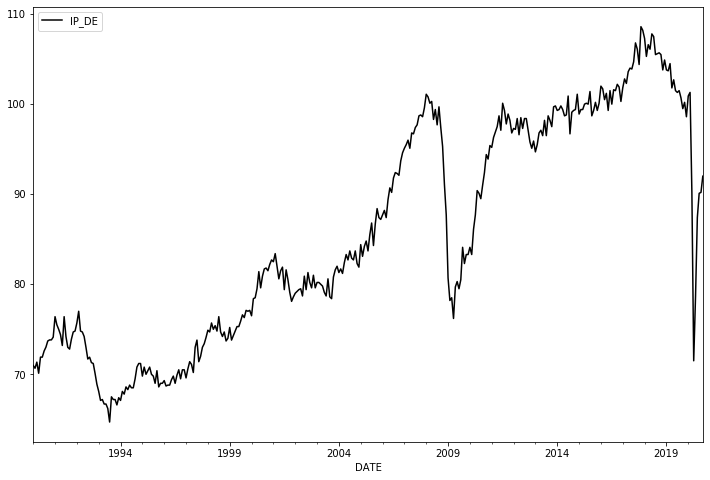

In [17]:
# plot the series
plt.rcParams["figure.figsize"] = (12,8)
ip.plot(color='black')
plt.show()

### Decomposition

You can test your intuition visually recognising multiplicative/additive decomposition series [here](https://kourentzes.com/forecasting/2014/11/09/additive-and-multiplicative-seasonality/)

In [58]:
# produce both additive and multiplicative decompositions

sdc_a = seasonal_decompose(ip, model='a') # this is the model-parameter's default setting
sdc_m = seasonal_decompose(ip, model='m')
additive_model = sdc_a.trend+sdc_a.seasonal #deterministic part of the decomposition
multiplicative_model = sdc_m.trend*sdc_m.seasonal

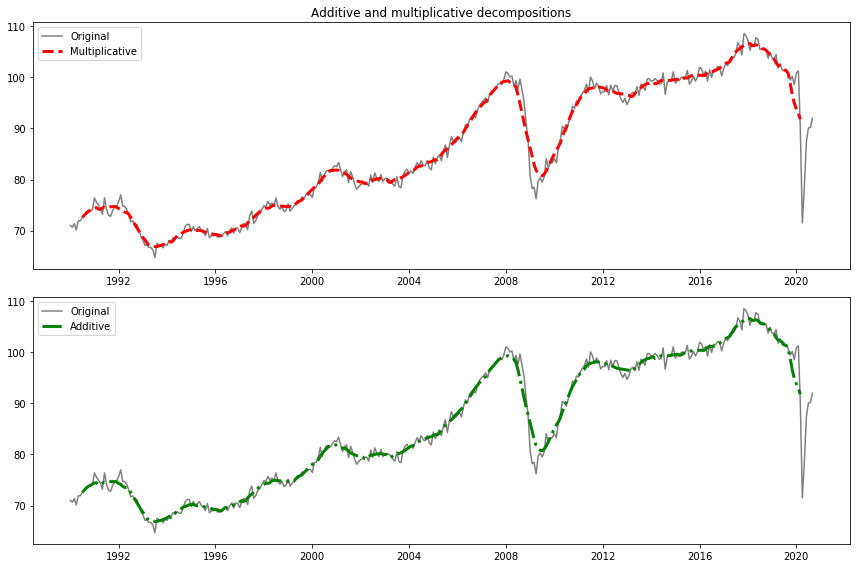

In [59]:
# plot the two decomposition models against the original data

# styling
plt.rcParams["figure.figsize"] = (12,8)
plt.figure(1)
plt.subplot(2,1,1)
plt.title('Additive and multiplicative decompositions')
plt.plot(ip, label = 'Original', color='grey')
plt.plot(multiplicative_model, label = 'Multiplicative',linestyle='--', color= 'red', linewidth=3)
plt.legend(loc = 'best')
plt.subplot(2,1,2)
plt.plot(ip, label = 'Original', color='grey')
plt.plot(additive_model, label = 'Additive',linestyle='-.', color='green', linewidth=3)
plt.legend(loc = 'best')
plt.tight_layout()

These two plots compare the deterministic parts of the series (trend and seasonal components combined) produced with a multiplicative and additive model (red and green series respectively), to the actual time series (grey series). 

Sometimes it is visually easy to detect which decomposition model suits our data best, in this case it is not, so we will need to compare decomposition residuals. The model with the highest residuals is the worse performing one. 

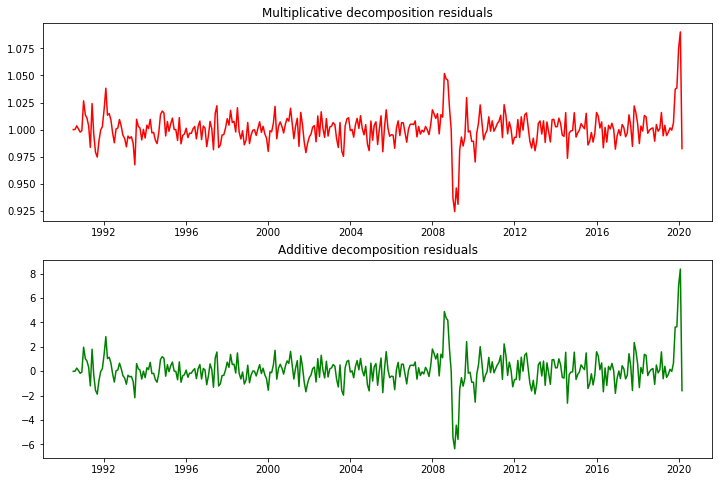

In [57]:
# compare residuals from the two decompositions using the .resid method

x = ip.index
residual_m = sdc_m.resid
plt.subplot(211)
plt.title('Multiplicative decomposition residuals')
plt.plot(x, residual_m, 'r')
residual_a = sdc_a.resid
plt.subplot(212)
plt.title('Additive decomposition residuals')
plt.plot(x, residual_a, 'g')
plt.show()

From this plot, there is not much difference when it comes to the average value of the series, but it does seem that the spread of values in the additive decomposition is much higher (look at the y axis of both plots), so we will pick a **multiplicative decomposition**.

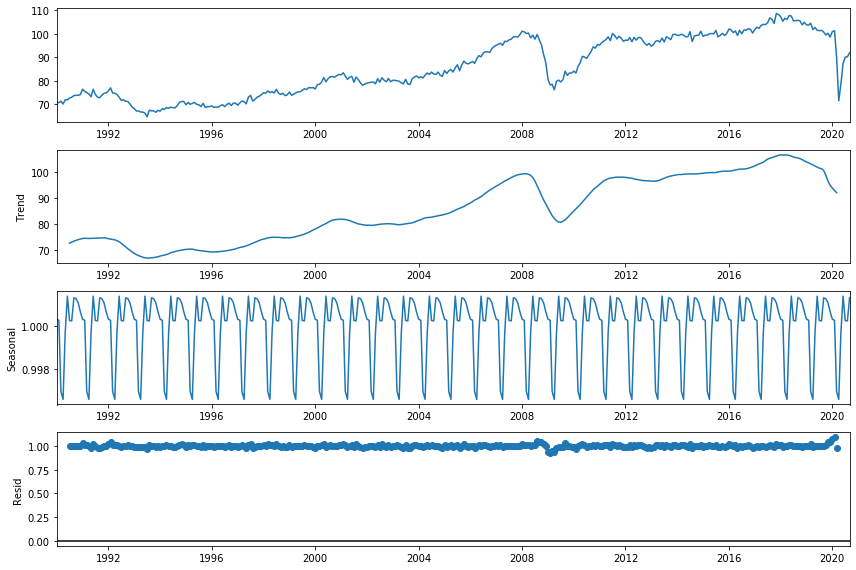

In [60]:
#decomposition properties

sdc_ip = seasonal_decompose(ip, model='multiplicative') #if you don't specify the decomposition model, default additive

sdc_ip.plot()
plt.show()

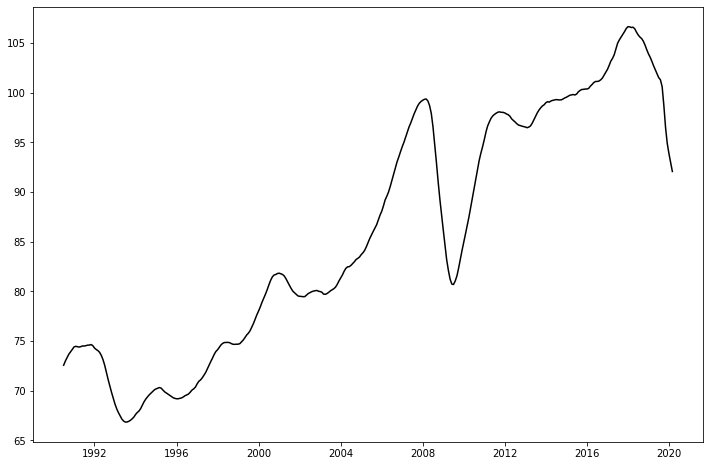

In [61]:
# you can isolate different components of the series

plt.plot(sdc_ip.trend, color= 'black')
plt.show()

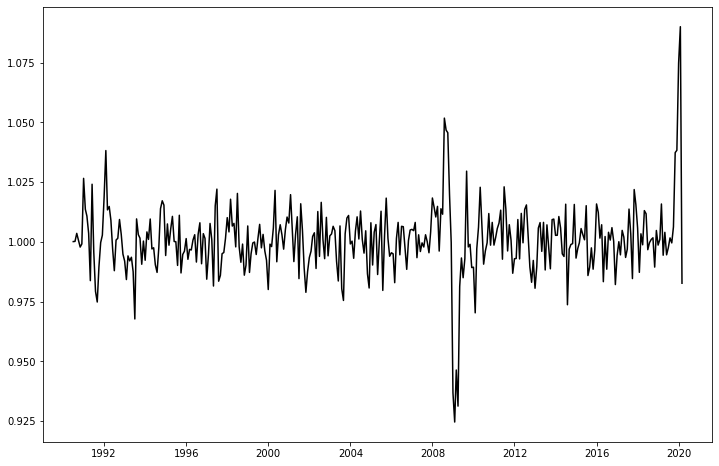

In [62]:
# isolate the residual

plt.plot(sdc_ip.resid, color='black')
plt.show()

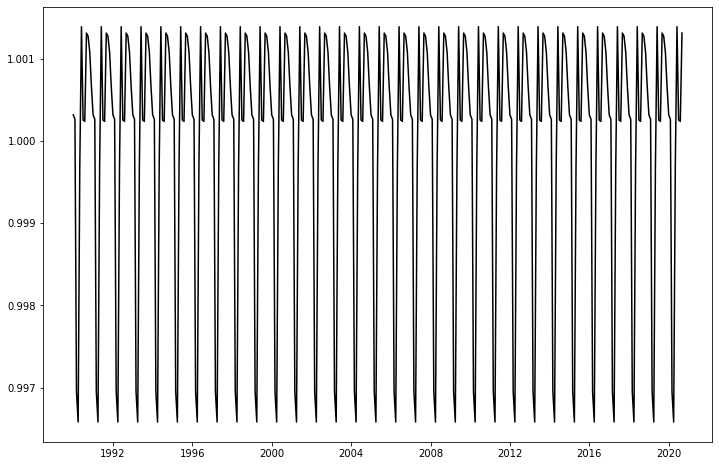

In [63]:
# isolate the seasonal component

plt.plot(sdc_ip.seasonal, color='black')
plt.show()

### Log transformation

When we decide a multiplicative decomposition is best for our series it is generally a good idea to apply a `log transformation` to it. By doing so, we effectively transform the series into an additive decomposition series of log values. 

This is true because, as we saw in the introduction the deterministic part of a series `Y` in context of a multiplicative decomposition will be obtained like this: `T`x`S`, where T is the trend component, and S the seasonal one. If we apply a log transformation to this product, we get find that the `log(Y) = log(T) + log(S)`. If you are interested you can read more about logarithm algebra [here](https://courses.lumenlearning.com/boundless-algebra/chapter/working-with-logarithms/#:~:text=produce%20that%20number.-,The%20logarithm%20of%20a%20product%20is%20the%20sum%20of%20the,the%20difference%20of%20the%20logarithms).

We need to do this because multiplicative series generally have **increasing variance** as the seasonal fluctuations increase in time. Instead, we need our data to have constant variance, so that we can make better predictions. 


In [18]:
ip = np.log(ip)

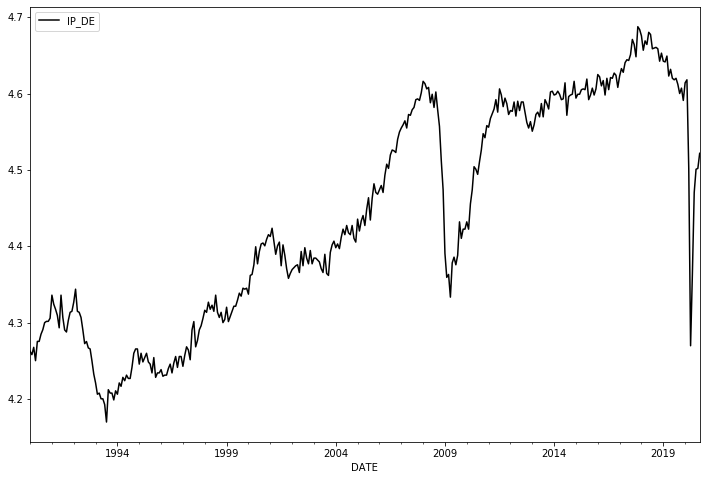

In [19]:
plt.rcParams["figure.figsize"] = (12,8)
ip.plot(color='black')
plt.show()

## Modelling: preparing data for ARIMA

### Plot the ACF and PACF

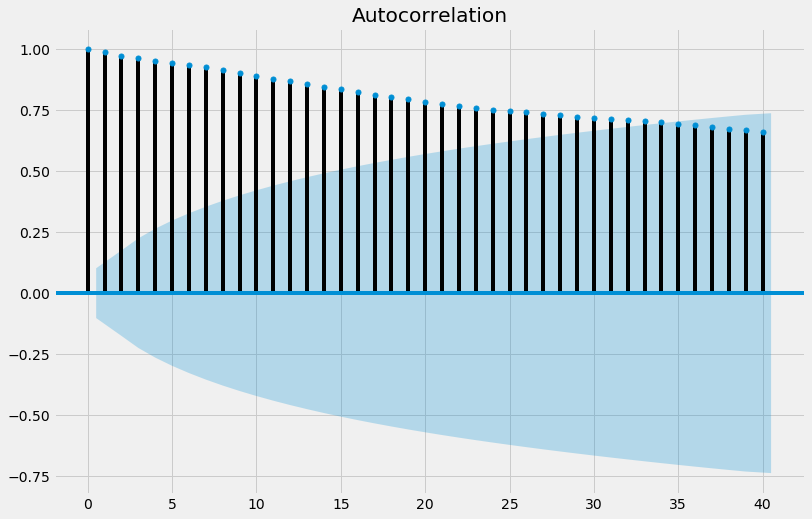

In [66]:
# plot the acf
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize']=(12,8)
plot_acf(ip,lags=40)
plt.show()

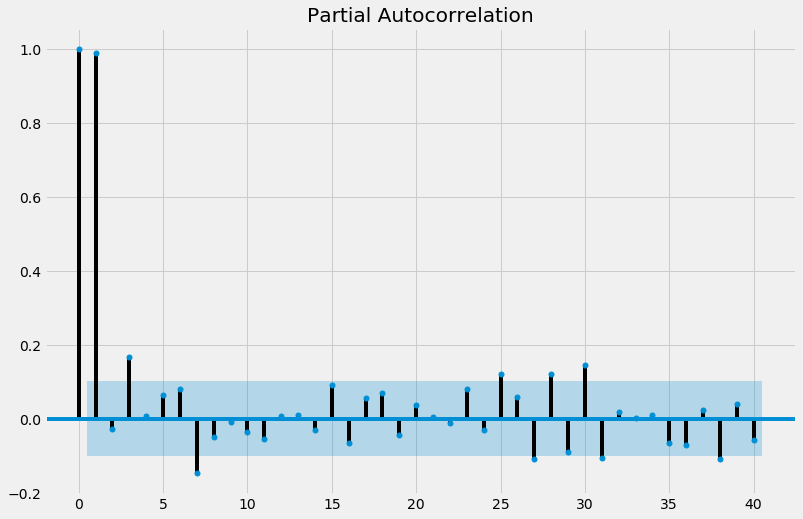

In [67]:
# plot the pacf
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize']=(12,8)
plot_pacf(ip,lags=40)
plt.show()

We can clearly observe the presence of a trend, while it is unclear that there is any seasonality. However, the presence of a trend tells us that the series is **not stationary**

### Stationarity: ADF test

The ADF test for stationarity.

H<sub>o</sub>: there is a unit root

H<sub>1</sub>: there is no unit root, the series is stationary
    
significance level (alpha): 0.05

This means that if you manage to reject the null hypothesis, `p-value < alpha`, your series is stationary


In [69]:
#stationarity - adf test

test = adfuller(ip) # aic automatically determines the max number of lags to be tested


In [71]:
test[1]# this is the p-value, compare it to critical level of the test

0.5431553752654616

We cannot reject the null hypothesis that there is a unit root (given that the p-value is not smaller than 0.05), hence the series, as expected from observing the acf plot, **is not stationary**.

### Stationarity: the KPSS test

KPSS test for stationarity:

H<sub>o</sub>: there is no unit root, the series is stationary

H<sub>1</sub>: there is a unit root

This means that if you manage to reject the null hypothesis, `p-value < alpha`, your series is NOT stationary

In [72]:
test_kpss = kpss(ip) # N.B.: the hypotheses are the opposite of the adf test

In [73]:
test_kpss[1] <0.05 # compare the p-value to the significance level

True

Based on the results of this test, we cannot reject the null hypothesis that there is a unit root, so the series **is not stationary**.

### Differencing

Remember that we need our series to be stationary in order to apply an ARIMA model to produce forecasts. The most common way to do that is through "differencing". We will subtract consecutive observations in order to remove trend and any seasonality in the series: we assume that increases in trend for consecutive periods are roughly constant, so differencing tends to be effective at removing trends.

In this workshop we will discussing the case when a series has a trend, but not strong seasonality (as we have seen from the ACF/PACF plots in this industrial production data).

**Important: differencing once makes a series stationary when there is a linear trend. Differencing twice makes a series stationary when there is a quadratic trend.**

In the online practice we will see that simple differencing is not always enough to remove both trend and seasonality - in that case we will resort to "seasonal differencing".

In [74]:
# differencing -1st order to eliminate the trend 
# drop na's resulting from differencing

ip_d = ip.diff(1).dropna()


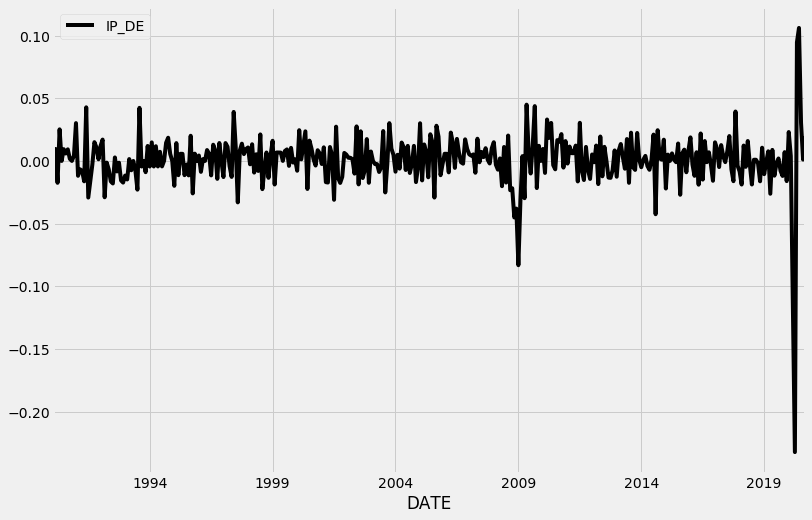

In [75]:
#let's visualise the 1st differenced series

ip_d.plot(color='black')
plt.show()

Clearly there is no visual evidence of a trend or of a pattern left, after differencing our series once. Let's however run the ADF and KPSS test again to check whether our data is stationary. If it is, then the `d` parameter input in our `ARIMA(p,d,q)` will be `d=1`.

### Run ADF and KPSS tests again

In [76]:
# run adf test again
# this time beautify output

test = adfuller(ip_d, autolag='AIC')
if test[1] < 0.05:
    print('P-value', round(test[1],5), '<0.05, so reject the null. The series is stationary!')
else:
    print('Unfortunately still not stationary - sorry!')

P-value 0.0 <0.05, so reject the null. The series is stationary!


In [77]:
# run kpss test again
# beautify output

test_kpss = kpss(ip_d, nlags='auto')
if test_kpss[1] < 0.05:
    print('P-value', round(test[1],5), '<0.05, so reject the null. The series is NOT stationary')
else:
    print('Yay! We do not reject the null: the series is stationary!')


Yay! We do not reject the null: the series is stationary!


First differencing our series has been enough to remove the trend, now let's have a look at the ACF plot to figure out if there is any seasonality left.

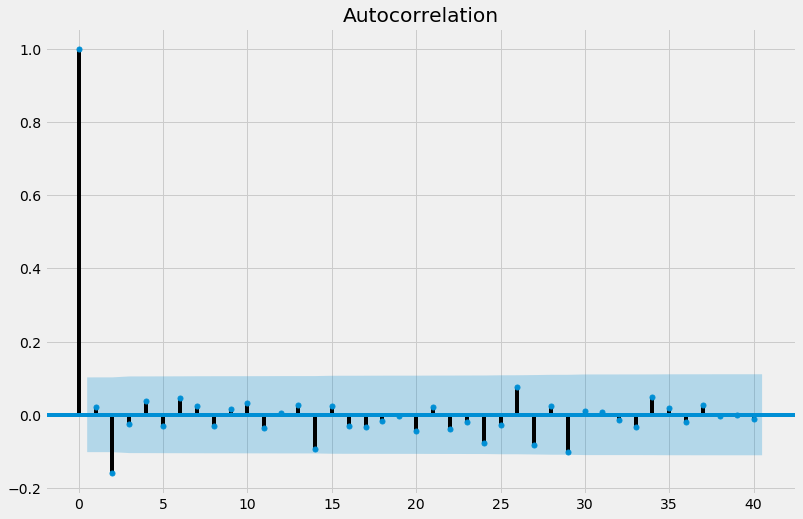

In [78]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize']=(12,8)
plot_acf(ip_d,lags=40)
plt.show()

From the ACF plot it does not seem to be the case that we have patterns recurring at a given seasonal period (at recurring time intervals, i.e. every month, every 3 months, every year) so we can be sure our series is truly stationary. 

So we can confirm our series is stationary, and `d`=1.

## Implement ARIMA

Implementing ARIMA requires a set of assumptions to hold:

- the data should be **stationary**, in other words its properties should not vary over time. This means that its mean and variance should be constant (homoskedastic residuals), which is why we had to apply differencing to make our series stationary. 

- the series should be **univariate**, that is be composed of only one variable. There are no other predictors (e.g. in an extension to ARIMA, SARIMAX, you will see that there are exceptions to this rule)

We verified that our series is stationary when differenced once, and that we only have one variable, `industrial production` in this dataset.  

**ARIMA is composed of three hyperparameters, which we need to input when running the `ARIMA()` function**:

- `p`: number of autoregressive terms (AR order)
- `d`: number of nonseasonal differences (differencing order) 
- `q`: number of moving-average terms (MA order)

**Important**: `ARIMA()` in `statsmodels` will perform the differencing for us, so we need to do it manually beforehand to understand what level of differencing is required for stationarity, in order to specify the `d` parameter when running the model. 

*However, your input series will be the non-differenced one as the function will do the differencing for you, you just need to specify how many differences are necessary for stationarity.*


`p` and `q` are chosen by looking at the PACF and ACF plots respectively. They are chosen by looking at the lag after which the autocorrelations become statistically insignificant. 

**Important**: we will be looking at the PACF/ACF plots of the **stationary series**, in other words, the differenced one. 

**Let's have a look at how all this works in practice**

### Plot the ACF/PACF of the stationary series

The first step is to plot the ACF and PACF plots of the stationary series, so that we can choose a value for the `p` and `q` parameters from the PACF and ACF plots respectively

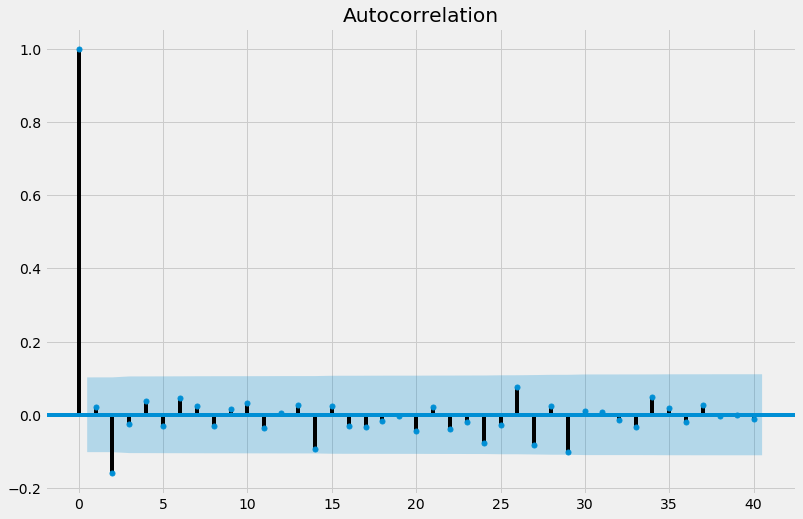

In [79]:
# plot acf of the differenced series

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize']=(12,8)
plot_acf(ip_d,lags=40)
plt.show()

Let's take a look at this ACF plot to choose the best `q` value. It seems like the last lag after which autocorrelations are statistically insignificant is 2, so we set an initial parameter of `q=2`

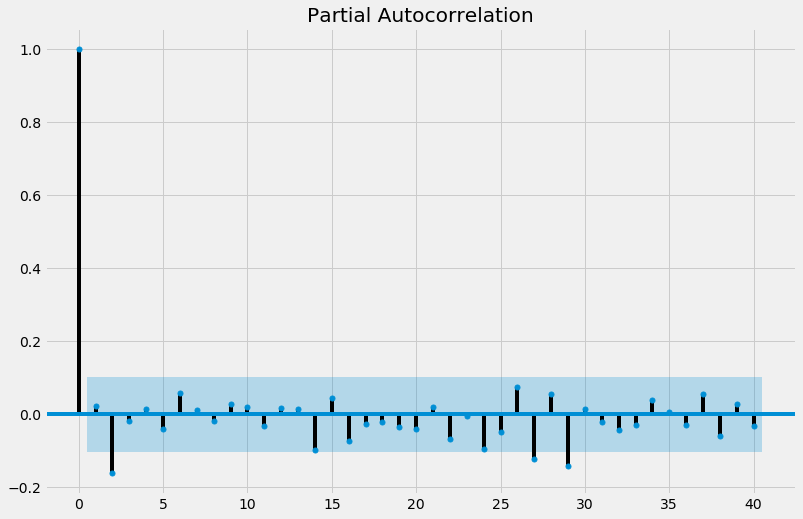

In [80]:
# plot pacf of the differenced series

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize']=(12,8)
plot_pacf(ip_d,lags=40)
plt.show()

The PACF plot looks very similar. There are some statistically significant partial autocorrelations at higher lags (e.g. 27,29), but those are likely to be due to randomness, there is a sharp cutoff after lag 2, so we will set an initial parameter `p=2`

Having looked at ACF, PACF plots and having carried out differencing to achieve stationarity we can set our initial parameters to:

- `p`: 2 (PACF plot)
- `d`: 1 (as we had to difference the series once to make it stationary)
- `q`: 2 (ACF plot)

**Note**: Fitting an ARIMA model looking at the ACF/PACF plot to choose will not yield the best possible model in most scenarios, but it is a good starting point. We will discuss how to optimise our choice of parameters in the online practice. 

### Train-test split

In [81]:
# produce a train test split

#split into train and test set - suggested 80-20 split, but you can choose your own split
nobs = 74
train, test = ip[0:-nobs], ip[-nobs:]

# Check size
print(train.shape)  
print(test.shape) 


(295, 1)
(74, 1)


### Fit the ARIMA(2,1,2) model

Now that we found our model parameters, let's run the first model, fit it and analyse it. Notice that we are using our original log transformed series and not the differenced one

In [82]:
# run and fit our first model

model = ARIMA(train, order=(2,1,2)) #order = (p,d,q) 
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.IP_DE   No. Observations:                  294
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 818.596
Method:                       css-mle   S.D. of innovations              0.015
Date:                Mon, 18 Jan 2021   AIC                          -1625.193
Time:                        11:46:32   BIC                          -1603.091
Sample:                    02-01-1990   HQIC                         -1616.342
                         - 07-01-2014                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0012      0.001      1.118      0.264      -0.001       0.003
ar.L1.D.IP_DE     0.6594      0.201      3.275      0.001       0.265       1.054
ar.L2.D.IP_DE    -0.1805      0.165     

This is not the best model we can find, as you can see from the `P>|z|` column (which indicates the p-value) most of the coefficients associated to the lags are statistically insignificant. However, it is still a good starting point

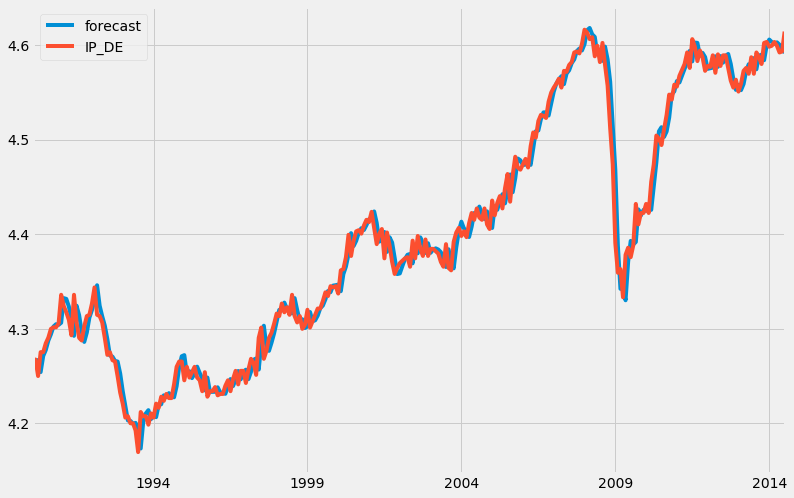

In [83]:
# plot our fit
# dynamic = False: If dynamic is False, then the in-sample lagged values are used for prediction.
# If `dynamic` is True, then in-sample forecasts are used in place of lagged dependent variables. 

model_fit.plot_predict(dynamic=False)
plt.show()

### Check residuals

An important part of analysing how good a model is relies on checking residuals. In general, we want them to:

- behave like white noise, and not show signs of patterns
- not have autocorrelation
- have a mean of 0, and have a symmetric distribution around the mean

If these conditions are not met, there is likely some pattern in our data that our model is not capturing. 

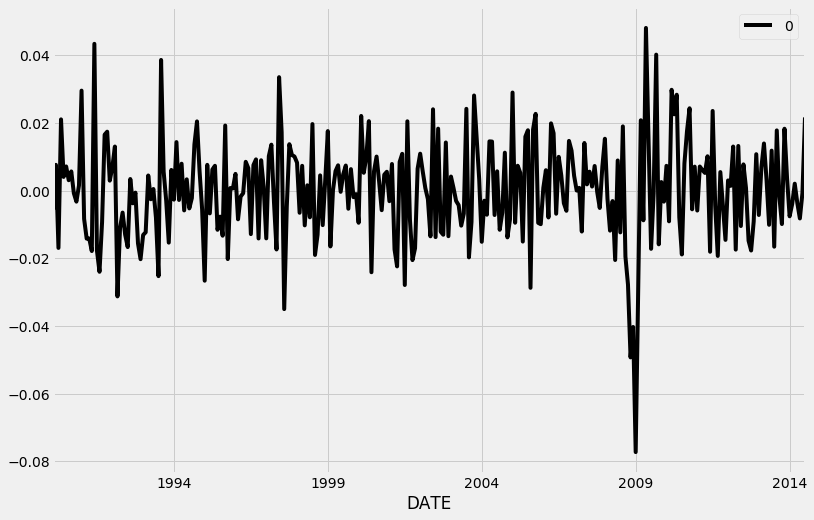

In [84]:
# check residuals of the model fit

residuals = pd.DataFrame(model_fit.resid)
residuals.plot(color='black')
plt.show()

This is a good sign, the residuals are mean 0 and seem to have a roughly constant variance with the exception of the last period

### Forecast 

Now that we have our model, let's use it to produce in-sample forecasts: forecast the values of the test set, which we will then compare to the actual values to evaluate performance. 

In [85]:
len(test) # we want to produce 74 forecasts for the same dates as the test set

74

In [86]:
# produce forecasts and confidence intervals using the model we fit above

fc, se, conf = model_fit.forecast(74, alpha=0.05)  # 95% confidence, alpha = 0.05

In [87]:
# transform the forecasts and upper/lower bounds of the confidence intervals to pd.Series()

fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

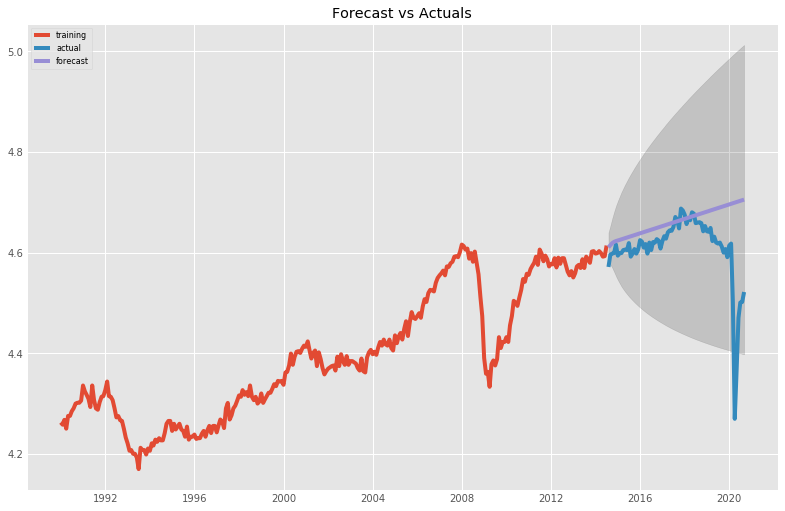

In [88]:
# plot the different series: forecast series and test set values

# styling
plt.rcParams["figure.figsize"] = (12,8)
plt.style.use('ggplot')

plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Transform the series back to level

Now that we have produced forecasts, let's revert the series back to level (reverse the log transformation). We can reverse a log transformation by applying its inverse operation: the exponential. The series will look exactly the same, only the units on the y axis will change

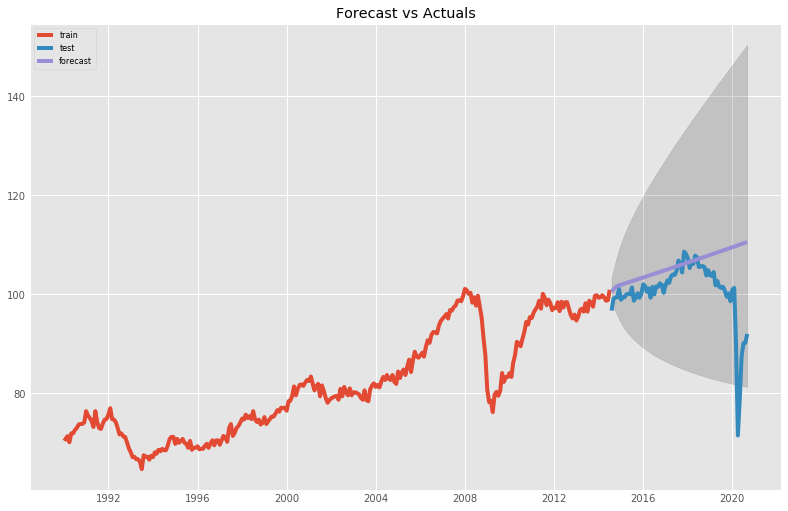

In [89]:
# apply np.exp() to the series before plotting them

# styling
plt.rcParams["figure.figsize"] = (12,8)
plt.style.use('ggplot')

plt.plot(np.exp(train), label='train')
plt.plot(np.exp(test), label='test')
plt.plot(np.exp(fc_series), label='forecast')
plt.fill_between(lower_series.index, np.exp(lower_series), np.exp(upper_series), 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Optional stretch

We have run an ARIMA model, but we have not discussed how to select the best "version" of this model, or more formally, the best "specification". We will discuss this further in the online practice, but we do this using the `AIC` criteria. `AIC` stands for `Akaike Information Criteria`.

We ideally want to select the version of the model with the lowest AIC possible. 

We can do this automatically using techniques such as `gridsearch`, or in-built functions such as `autoarima`, which was a famous R function. Let's try the second: we will find an alternative model to the one above using autoarima, and compare the AIC we obtain with the previous one.

In [ ]:
model = pm.auto_arima(ip, start_p=0, start_q=0,
                      test='adf',       # dftest to find 'd' --> stationary
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series, monthly
                      d=None,           # let model determine 'd'
                      seasonal=False,   # when seasonal=True, sarima is run
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)



In [ ]:
# run and fit the new model ARIMA(0,1,0)

model = ARIMA(ip, order=(0,1,0)) #order = (p,d,q) 
model_fit = model.fit(disp=0)


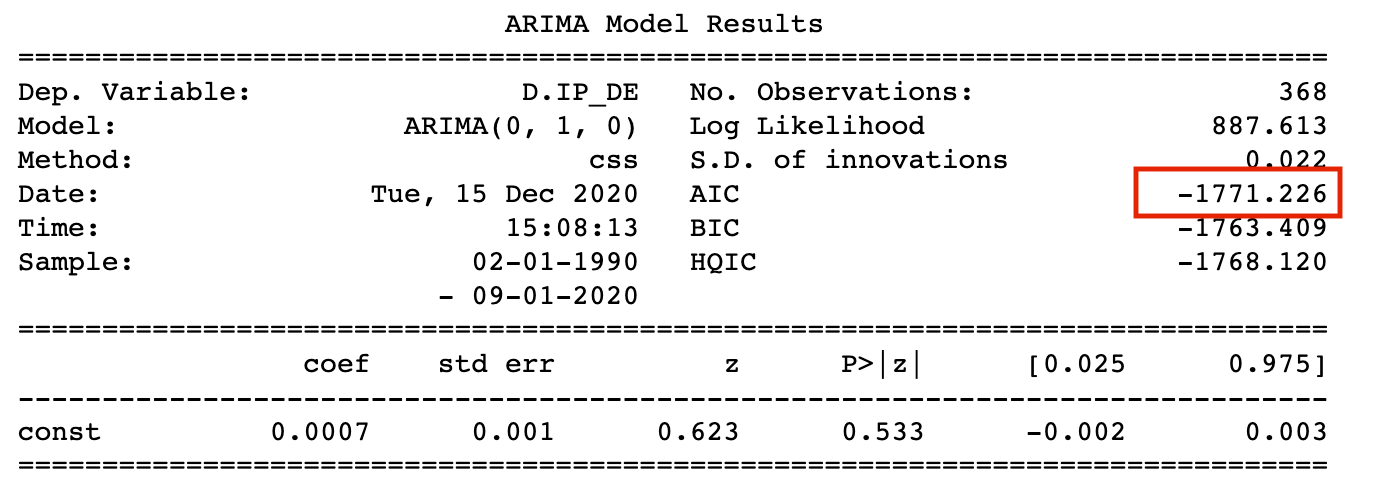

The `ARIMA(0,1,0)` has an AIC of -1771.226 (the red box above) vis a vis an `AIC` of  -1773.042 for the first model we ran `ARIMA(2,1,2)`. 

Given that the AIC for the latter is smaller, it is a better choice. 

### Next steps

In the online practice we will discuss ways to find the optimal model, including automated techniques such as grid search. We will also discuss model evaluation techniques.